<a href="https://colab.research.google.com/github/gayathry2612/ML/blob/master/PneumoniaClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Editor : Gayathry Dasika
Forked notebook. 

Things to add 
1.   Data Augumentation by creating copies (done)
> Results : Oversampled normal training set, applied a variation to both normal and pneumonia. 1500 random validation set of balanced dataset is giving an accuracy metric of 97%. This needs to repeat the same performance on the test set. The test set is reporting an accuracy of 80%

2. No variations added on Normal & Pneumonia. 

Permutations to try
1. Validation set variations. Have more training set. 
2. Train with cross validation
3. Report more evaluation metrics 



In [ ]:
#These are some basic Utilites we will need.
import os #To handle dataset
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import ImageFolder #to load data from folder
from torch.utils.data import DataLoader 
import torchvision.transforms as tt #to tansform image into tensors
from torch.utils.data import random_split #for spliting dataset into train and validation set
from torchvision.utils import make_grid 

#to draw images in notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


In [ ]:
from PIL import Image 
  
# creating a image object 
#im1 = Image.open(r"C:\Users\sadow984\Desktop\i3.PNG") 
  
# copying image to another image object 
#im2 = im1.copy() 
  
# shows the copied image 
#im2.show() 

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
!pip install opendatasets --upgrade --quiet


In [ ]:
import opendatasets as od

In [ ]:
dataset_url='https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia'
od.download(dataset_url) 

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dasikag
Your Kaggle Key: ··········


  0%|          | 11.0M/2.29G [00:00<00:22, 109MB/s]

100%|██████████| 2.29G/2.29G [00:30<00:00, 81.2MB/s]


In [ ]:
data_dir = './chest-xray-pneumonia/'

In [ ]:
import shutil 
os.listdir(data_dir + 'chest_xray')

['chest_xray', 'val', '__MACOSX', 'train', 'test']

In [ ]:
shutil.rmtree(data_dir + 'chest_xray/__MACOSX')
shutil.rmtree(data_dir + 'chest_xray/chest_xray')


In [ ]:
data_dir = data_dir+'chest_xray'
os.listdir(data_dir)

['val', 'train', 'test']

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

5856

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 5856
    Root location: ./chest-xray-pneumonia/chest_xray

In [ ]:
dataset.classes

['test', 'train', 'val']

0


(<PIL.Image.Image image mode=RGB size=1857x1317 at 0x7F7C3CC1B050>, 0)

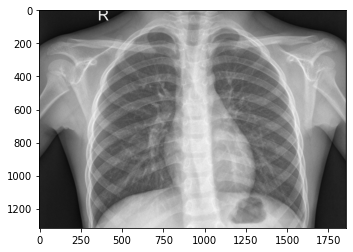

In [ ]:
img, label = dataset[0]
plt.imshow(img)
print(label)

dataset[0]

1


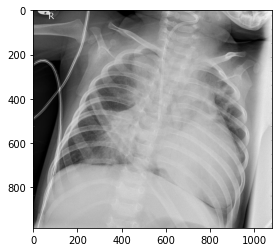

In [ ]:
img, label = dataset[2002]
plt.imshow(img)
print(label)

1


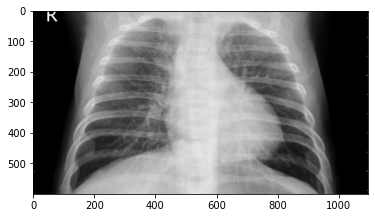

In [ ]:
img, label = dataset[2500]
plt.imshow(img)
print(label)

In [ ]:
for cls in os.listdir(data_dir + '/train'):
  print(cls,':',len(os.listdir(data_dir+'/train/'+cls)))

NORMAL : 3865
PNEUMONIA : 3875


In [ ]:
for cls in os.listdir(data_dir + '/test'):
  print(cls,':',len(os.listdir(data_dir+'/test/'+cls)))

NORMAL : 234
PNEUMONIA : 390


In [ ]:
for cls in os.listdir(data_dir + '/val'):
  print(cls,':',len(os.listdir(data_dir+'/val/'+cls)))

NORMAL : 8
PNEUMONIA : 8


In [ ]:
#shutil.move(data_dir+'/train/PNEUMONIA/',data_dir+'/PNEUMONIA/')
#shutil.rmtree(data_dir+'/train/')
#os.mkdir(data_dir+'/train/')
#shutil.move(data_dir+'/NORMAL/',data_dir+'/train/NORMAL')
#shutil.move(data_dir+'/PNEUMONIA/',data_dir+'/train/PNEUMONIA/')

In [ ]:
# Create an oversampling dataset by creating copies of the normal file - have to enclose it in a while loop to make sure it will somehow run. its a colab thing - may be a limit on the file copies in a given time.  
j=0
while j < 15:  
  # List files and directories 
  my_normal_files = os.listdir(data_dir+'/train/NORMAL/')

  for i in range(len(my_normal_files),len(os.listdir(data_dir+'/train/PNEUMONIA/'))):
    k = np.random.randint(low=0, high=len(my_normal_files), size=None)
    f = my_normal_files[k]
    source = data_dir+'/train/NORMAL/'+f
    destination = data_dir+'/train/NORMAL/NORMAL-'+f
    dest = shutil.copyfile(source, destination) 
    i+=1
  print(i)
  # Pick a random file and create a copy of it 
  print("Files copied") 
  print("Original : ", len(my_normal_files))
  print("Copied : ",len(os.listdir(data_dir+'/train/NORMAL/')))
  j+=1
  print(j)

3875
Files copied
Original :  3873
Copied :  3874
1
3875
Files copied
Original :  3874
Copied :  3874
2
3875
Files copied
Original :  3874
Copied :  3875
3
3875
Files copied
Original :  3875
Copied :  3875
4
3875
Files copied
Original :  3875
Copied :  3875
5


In [ ]:
# Add variations to the dataset 
dataset = ImageFolder(data_dir+'/train', 
                      transform=tt.Compose([tt.Resize(64),#resize the image into 64x64
                                            tt.CenterCrop(64),#crop image from centre
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),# keep center invariant
                                            tt.ToTensor()
                                           ]))

torch.Size([3, 64, 64])
0


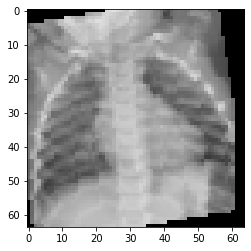

In [ ]:
img,label=dataset[50] 
plt.imshow(img.permute(1,2,0))
print(img.shape)
print(label)

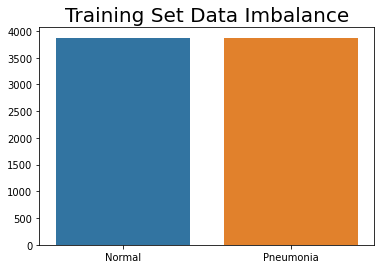

In [ ]:
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Imbalance', fontsize=20)
plt.show()

In [ ]:
#Making a validation set with 1500 samples

val_size=1500
train_size=len(dataset)-val_size
train_data,val_data=random_split(dataset,[train_size,val_size])
len(train_data),len(val_data)

(6250, 1500)

In [ ]:
batch_size=64
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

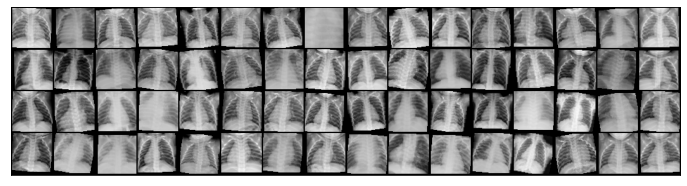

In [ ]:
show_batch(train_dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 112 x 112

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4,4), # output: 128 x 28x 28

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(4), # output: 256 x 4 x 4
            
            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(CnnModel(), device)
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): AdaptiveMaxPool2d(output_size=4)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features=512, bias=True)
    (19):

In [ ]:
for batch in train_dl:
  images,labels=batch
  print('image shape',images.shape)
  print(images.device)
  preds=model(images)
  print('preds shape:',preds.shape)
  break

image shape torch.Size([64, 3, 64, 64])
cuda:0
preds shape: torch.Size([64, 2])


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate( model , val_dl )]
history

[{'val_acc': 0.47058987617492676, 'val_loss': 0.6945925951004028}]

In [ ]:
history+=fit(5,0.001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.5945, val_loss: 0.3555, val_acc: 0.8514
Epoch [1], train_loss: 0.2583, val_loss: 0.2192, val_acc: 0.9102
Epoch [2], train_loss: 0.1995, val_loss: 0.1803, val_acc: 0.9425
Epoch [3], train_loss: 0.1651, val_loss: 0.1647, val_acc: 0.9447
Epoch [4], train_loss: 0.1705, val_loss: 0.1578, val_acc: 0.9442


In [ ]:
history+=fit(5,0.0001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.1184, val_loss: 0.1165, val_acc: 0.9567
Epoch [1], train_loss: 0.1043, val_loss: 0.0998, val_acc: 0.9627
Epoch [2], train_loss: 0.1004, val_loss: 0.1149, val_acc: 0.9571
Epoch [3], train_loss: 0.0983, val_loss: 0.0983, val_acc: 0.9685
Epoch [4], train_loss: 0.0869, val_loss: 0.0902, val_acc: 0.9649


In [ ]:
history+=fit(5,0.0001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.0919, val_loss: 0.0869, val_acc: 0.9623
Epoch [1], train_loss: 0.0813, val_loss: 0.0840, val_acc: 0.9681
Epoch [2], train_loss: 0.0859, val_loss: 0.0801, val_acc: 0.9716
Epoch [3], train_loss: 0.0817, val_loss: 0.0796, val_acc: 0.9690
Epoch [4], train_loss: 0.0798, val_loss: 0.0759, val_acc: 0.9697


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

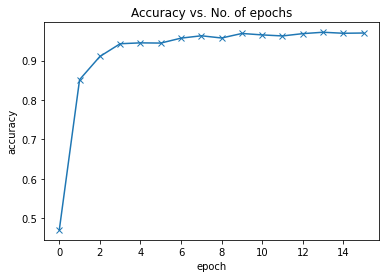

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

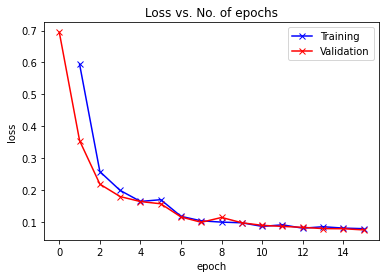

In [ ]:
plot_losses(history)

In [ ]:
"""
testset = ImageFolder(data_dir+'/test', 
                      transform=tt.Compose([tt.Resize(64),
                                            tt.CenterCrop(64),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                           ]))
"""


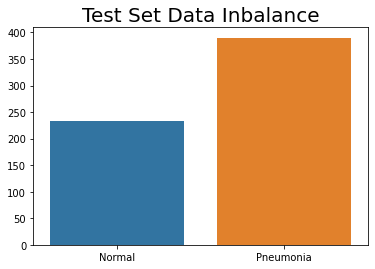

In [ ]:
test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/test/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/test/PNEUMONIA')])]})


sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [ ]:
test_loader = DeviceDataLoader(DataLoader(testset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.7946428060531616, 'val_loss': 0.835728645324707}

In [ ]:
def predict_image(img, model,classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

def show_predict(data):
   size=16
   for i in range(size):
     img,label=data[i] #Take image and label
     preds=predict_image(img,model,dataset.classes) #predict using predict_function
     #print image with predicted label and target
     fig, ax = plt.subplots(figsize=(12, 6))
     plt.subplot(4,4,1+i)
     plt.imshow(img.permute(1,2,0))
     print('Image number:',i,'Target:',dataset.classes[label])
     print('Predicted:',preds)
     plt.show()

Image number: 0 Target: NORMAL
Predicted: PNEUMONIA


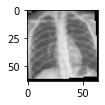

Image number: 1 Target: NORMAL
Predicted: NORMAL


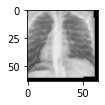

Image number: 2 Target: NORMAL
Predicted: PNEUMONIA


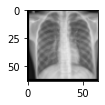

Image number: 3 Target: NORMAL
Predicted: PNEUMONIA


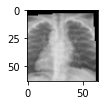

Image number: 4 Target: NORMAL
Predicted: PNEUMONIA


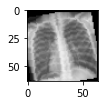

Image number: 5 Target: NORMAL
Predicted: NORMAL


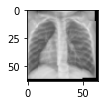

Image number: 6 Target: NORMAL
Predicted: PNEUMONIA


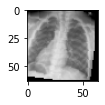

Image number: 7 Target: NORMAL
Predicted: PNEUMONIA


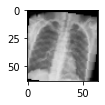

Image number: 8 Target: NORMAL
Predicted: PNEUMONIA


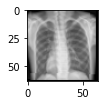

Image number: 9 Target: NORMAL
Predicted: NORMAL


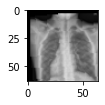

Image number: 10 Target: NORMAL
Predicted: PNEUMONIA


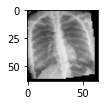

Image number: 11 Target: NORMAL
Predicted: PNEUMONIA


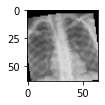

Image number: 12 Target: NORMAL
Predicted: NORMAL


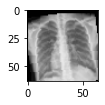

Image number: 13 Target: NORMAL
Predicted: PNEUMONIA


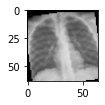

Image number: 14 Target: NORMAL
Predicted: PNEUMONIA


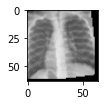

Image number: 15 Target: NORMAL
Predicted: PNEUMONIA


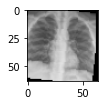

In [ ]:
show_predict(testset)

In [ ]:
dataset = ImageFolder(data_dir+'/train', 
                      transform=tt.Compose([tt.Resize((224,224)),
                                            #tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                           ]))

In [ ]:
val_size=1500
train_size=len(dataset)-val_size
train_data,val_data=random_split(dataset,[train_size,val_size])
len(train_data),len(val_data)

(3716, 1500)

In [ ]:
batch_size=64
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
from torchvision import models

class TransferModel(ImageClassificationBase):
    def __init__(self):
        super(TransferModel, self).__init__()
        #obtain the ResNet model from torchvision.model library
        self.model = torchvision.models.resnet152(pretrained=True)
        #build our classifier and since we are classifying the images into NORMAL and PNEMONIA, we output a two-dimensional tensor.
        self.classifier = nn.Sequential(
        nn.Linear(self.model.fc.in_features,2),
        nn.LogSoftmax(dim=1))
        #Requires_grad = False denies the ResNet model the ability to update its parameters hence make it unable to train.
        for params in self.model.parameters():
            params.requires_grad = False
            #We replace the fully connected layers of the base model(ResNet model) which served as the classifier with our custom trainable classifier.
        self.model.fc = self.classifier

    def forward(self, x):
      return self.model(x)

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

In [ ]:
model1 = TransferModel()
to_device(model1, device);

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
history1 = [evaluate(model1, valid_dl)]
history1

[{'val_acc': 0.51171875, 'val_loss': 0.7080641984939575}]

In [ ]:
epochs = 16
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history1 += fit_one_cycle(epochs, max_lr, model1, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], train_loss: 0.5678, val_loss: 0.5413, val_acc: 0.7490



Epoch [1], train_loss: 0.3942, val_loss: 0.3008, val_acc: 0.9153



Epoch [2], train_loss: 0.2563, val_loss: 0.2230, val_acc: 0.9063



Epoch [3], train_loss: 0.2006, val_loss: 0.1935, val_acc: 0.9250



Epoch [4], train_loss: 0.1723, val_loss: 0.1652, val_acc: 0.9326



Epoch [5], train_loss: 0.1958, val_loss: 0.1829, val_acc: 0.9241



Epoch [6], train_loss: 0.1592, val_loss: 0.1775, val_acc: 0.9306



Epoch [7], train_loss: 0.1795, val_loss: 0.1551, val_acc: 0.9329



Epoch [8], train_loss: 0.1443, val_loss: 0.1502, val_acc: 0.9370



Epoch [9], train_loss: 0.1345, val_loss: 0.1375, val_acc: 0.9519



Epoch [10], train_loss: 0.1365, val_loss: 0.1355, val_acc: 0.9440



Epoch [11], train_loss: 0.1281, val_loss: 0.1358, val_acc: 0.9392



Epoch [12], train_loss: 0.1381, val_loss: 0.1304, val_acc: 0.9479



Epoch [13], train_loss: 0.1316, val_loss: 0.1443, val_acc: 0.9468



Epoch [14], train_loss: 0.1367, val_loss: 0.1379, val_acc: 0.9478



Epoch [15], train_loss: 0.1273, val_loss: 0.1333, val_acc: 0.9519
CPU times: user 2min 31s, sys: 1min 43s, total: 4min 14s
Wall time: 20min 25s


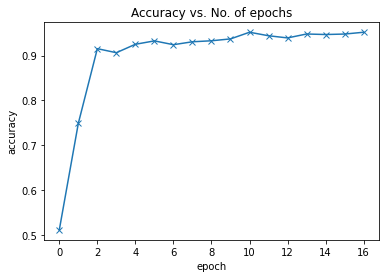

In [ ]:
 plot_accuracies(history1)


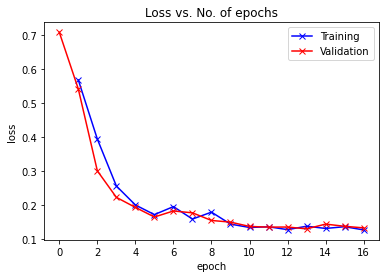

In [ ]:
plot_losses(history1)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

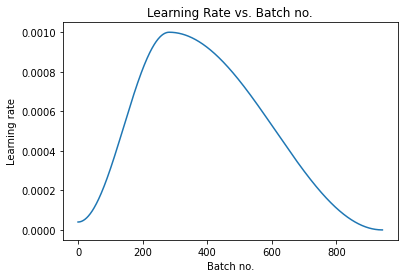

In [ ]:
plot_lrs(history1)